 # 0.0 IMPORTAÇÕES E FUNÇÕES DE AJUDA


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import xgboost as xgb

import pickle

from scipy                      import stats as ss
from sklearn.preprocessing      import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection    import train_test_split
from sklearn.ensemble           import RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model       import LinearRegression, LogisticRegression
from sklearn.metrics            import mean_absolute_error, mean_squared_error
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.tree               import DecisionTreeClassifier
from sklearn.svm                import SVC
from sklearn.naive_bayes        import GaussianNB
from sklearn.neural_network     import MLPClassifier
from sklearn.model_selection    import KFold
from scikitplot.metrics         import plot_confusion_matrix, plot_roc_curve, plot_cumulative_gain
from sklearn.metrics            import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, plot_roc_curve
from sklearn.metrics            import plot_confusion_matrix


In [3]:
mms = MinMaxScaler()
rs = RobustScaler()

In [4]:
df_raw = pd.read_csv('data\cardio_train.csv', sep=';')
df_raw.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [306]:
def cross_valid_model(model_name, model, X, y, verbose=1, X_size = 0.75):  
    X.index, y.index = np.arange(0, len(X), 1), np.arange(0, len(X), 1)
    results = list()
    accuracy, precision, recall, f_score, roc_auc = list(), list(), list(), list(), list()
    
    for k in range(int(1/(1 - X_size))):
        if verbose == 1: 
            print(f'Kfold: {k+1}')
    
        X_train = X[((X.index <= int(len(X) * (X_size - (k*(1 - X_size)))))) | (X.index > int((len(X) * (1 - (k*(1 - X_size))))))]
        y_train = y[((y.index <= int(len(y) * (X_size - (k*(1 - X_size)))))) | (y.index > int((len(y) * (1 - (k*(1 - X_size))))))]

        X_test = X[((X.index > int(len(X) * (X_size - (k*(1 - X_size)))))) & (X.index <= int((len(X) * (1 - (k*(1 - X_size))))))]
        y_test = y[((y.index > int(len(y) * (X_size - (k*(1 - X_size)))))) & (y.index <= int((len(y) * (1 - (k*(1 - X_size))))))]

        pred = model.fit(X_train, y_train)

        yhat_model = pred.predict(X_test)
      
        accuracy.append(accuracy_score(yhat_model, y_test))
        precision.append(precision_score(yhat_model, y_test))
        recall.append(recall_score(yhat_model, y_test))
        f_score.append(f1_score(yhat_model, y_test))
        roc_auc.append(roc_auc_score(yhat_model, y_test))

    results = {'accuracy_score': np.mean(accuracy),
             'precision_score': np.mean(precision),
             'recall_score': np.mean(recall),
             'f_score': np.mean(f_score),
             'roc_auc': np.mean(roc_auc)}
    results = pd.DataFrame(results, index=[model_name])
                 
   
    return results


# 1.0 DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1 Tamanho do DataSet

In [7]:
print(f'Números de linhas: {df1.shape[0]}')
print(f'Números de colunas: {df1.shape[1]}')

Números de linhas: 70000
Números de colunas: 13


## 1.2 Nomes das Colunas

In [8]:
df1.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

## 1.3 Tipos de Dados

In [9]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.5 Estatística Descritiva

In [11]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

In [12]:
# Tendencia Central - Media e Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Despesão - Desvio Padrão, Mínimo, Máximo, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4,ct1, ct2, d1, d5, d6]).T.reset_index()

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,99999.0,99999.0,49972.419900,50001.5,28851.096242,-0.001278,-1.198374
1,age,10798.0,23713.0,12915.0,19468.865814,19703.0,2467.234044,-0.307055,-0.823447
2,gender,1.0,2.0,1.0,1.349571,1.0,0.476835,0.630960,-1.601935
3,height,55.0,250.0,195.0,164.359229,165.0,8.210068,-0.642187,7.943653
4,weight,10.0,200.0,190.0,74.205690,72.0,14.395654,1.012070,2.586825
5,ap_hi,-150.0,16020.0,16170.0,128.817286,120.0,154.010319,85.296214,7580.074738
6,ap_lo,-70.0,11000.0,11070.0,96.630414,80.0,188.471184,32.114083,1425.914585
7,cholesterol,1.0,3.0,2.0,1.366871,1.0,0.680245,1.587123,0.993901
8,gluc,1.0,3.0,2.0,1.226457,1.0,0.572266,2.397462,4.294377
9,smoke,0.0,1.0,1.0,0.088129,0.0,0.283482,2.905867,6.444250


# 2.0 FEATURE ENGENEERING

In [13]:
df2 = df1.copy()

In [14]:
# Criando a variável ano de nascimento.
df2['born_year'] = df2['age'].apply(lambda x: (dt.datetime.today() - dt.timedelta(days=x)).year)

# Criando coluna IMC
df2['imc'] = df2.apply(lambda x: x['weight'] / (x['height']/100)**2, axis=1)

# Trocando os valores da variável gender de 1-2 para 0-1
df2['gender'] = df2['gender'].apply(lambda x: 0 if x == 2 else 1)

# Criando coluna sobre hipertensão
df2['blood_pressure'] = df2[['ap_hi', 'ap_lo']].apply(lambda x: 'normal' if ((x['ap_lo'] <= 80) & (x['ap_hi'] <= 120 )) else
                                        'elevated' if (x['ap_lo'] <= 80) & (x['ap_hi'] > 120 | x['ap_hi'] <= 129) else
                                        'hypertension stage 1' if ((x['ap_lo'] > 80) | x['ap_lo'] <= 89 ) |  (x['ap_hi'] > 130 | x['ap_hi'] <= 139) else
                                        'hypertension stage 2' if (x['ap_lo'] >= 90) |  (x['ap_hi'] >= 140 )
                                        else 'NONE', axis=1)


# 3.0 FILTRAGEM DE DADOS

In [15]:
df3 = df2.copy()

In [16]:
# Removendo inconsistencias na pressão.
for i in range(len(df3)):
    if df3.loc[i, 'ap_hi'] < df3.loc[i, 'ap_lo']:
        df3 = df3.drop(i)

# Removendo inconsistencias na altura.
df3 = df3[df3['height'] > 130]
df3 = df3[df3['height'] < 210]

# Removendo inconsistencias na variável peso.
df3 = df3[df3['weight'] > 45]

# Removendo inconsistencias na pressão.
df3 = df3[df3['ap_lo'] > 50]
df3 = df3[df3['ap_lo'] < 170]
df3 = df3[df3['ap_hi'] > 80]
df3 = df3[df3['ap_hi'] < 210]


# 4.0 ANÁLISE EXPLORATÓRIA DE DADOS

In [17]:
df4 = df3.copy()

## 4.1 Análise Univariada

## 4.2 Análise Bivariada

1 - Pessoas com mais idade, em média tem mais propenção a ter um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

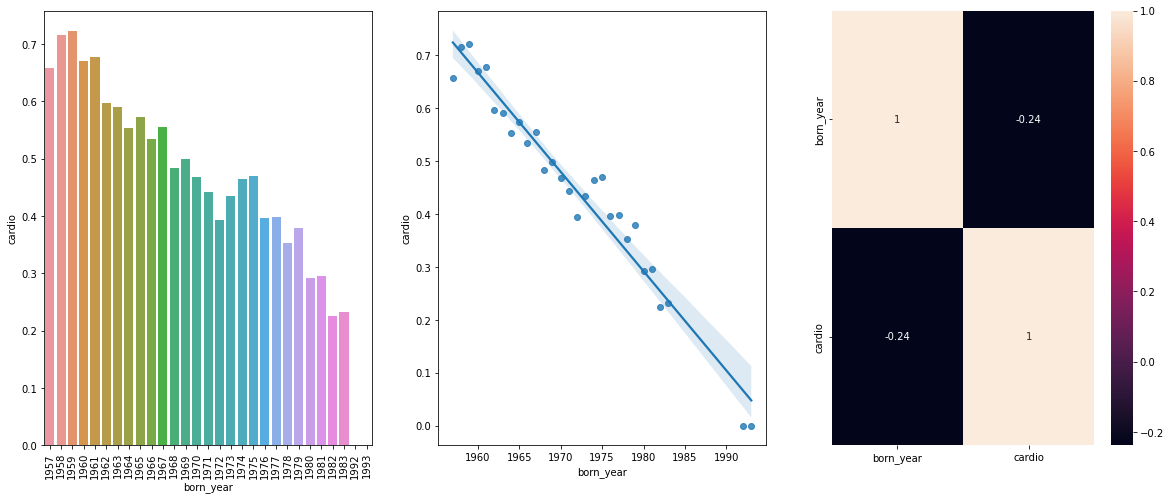

In [18]:
aux = df4[['born_year', 'cardio']].groupby('born_year').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='born_year', y='cardio', data=aux)
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.regplot(x='born_year', y='cardio', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4[['born_year', 'cardio']].corr(method='pearson'), annot=True)

2 - Homens e Mulheres tem em média chances diferentes de sofrer um ataque cardiaco. (Falso!)

<AxesSubplot:>

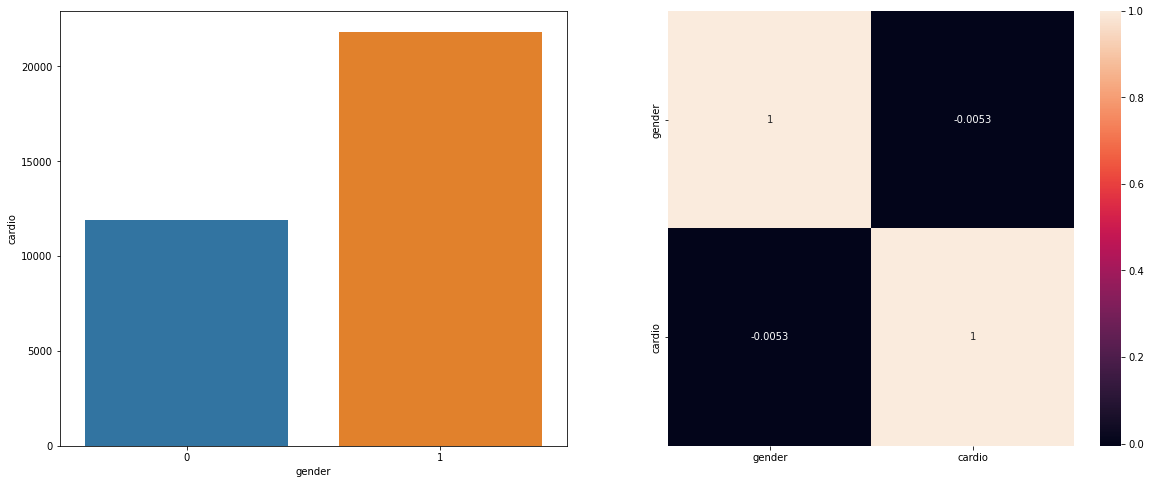

In [19]:
aux = df4[['gender', 'cardio', 'age']].groupby('gender').sum().reset_index()
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='gender', y='cardio', data=aux)
plt.subplot(1,2,2)
sns.heatmap(df4[['gender', 'cardio']].corr(method='pearson'), annot=True)

3 - Altura não aumenta as chances de ataque cardiaco. (Verdadeiro)

<AxesSubplot:>

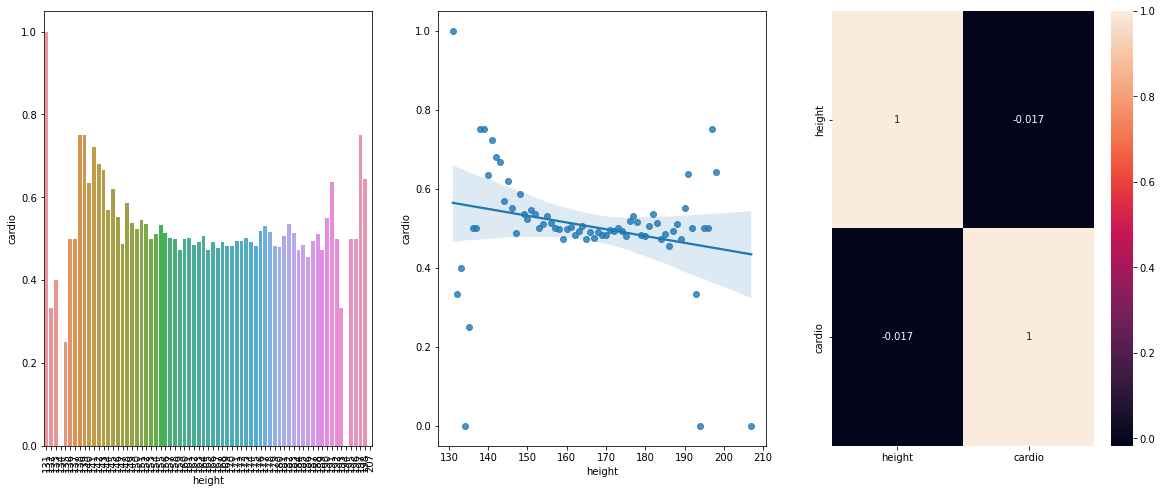

In [20]:
aux = df4[['height', 'cardio']].groupby('height').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='height', y='cardio', data=aux)
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.regplot(x='height', y='cardio', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4[['height', 'cardio']].corr(method='pearson'), annot=True)

4 - Quando maior o peso da pessoa, maior a chance de ela ter um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

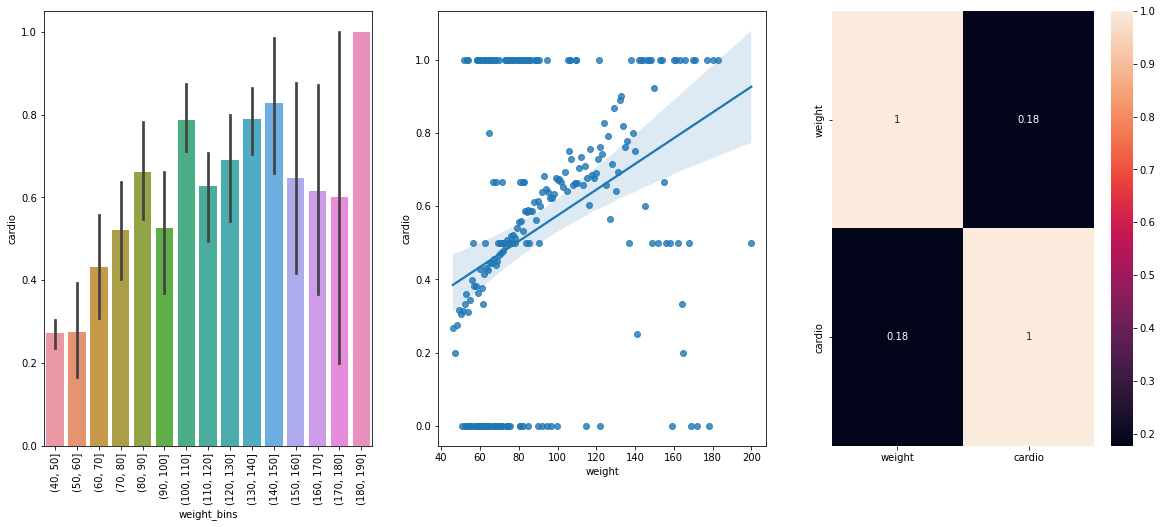

In [21]:
aux = df4[['weight', 'cardio']].groupby('weight').mean().reset_index()


bins = list(np.arange(40,200, 10))

aux['weight_bins'] = pd.cut(aux['weight'], bins=bins)
aux1 = aux[['weight_bins', 'cardio']].groupby('weight_bins').sum().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='weight_bins', y='cardio', data=aux)
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.regplot(x='weight', y='cardio', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4[['weight', 'cardio']].corr(method='pearson'), annot=True)

5 - Quanto pior o quadro de hypertensão, maior é a chance de um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

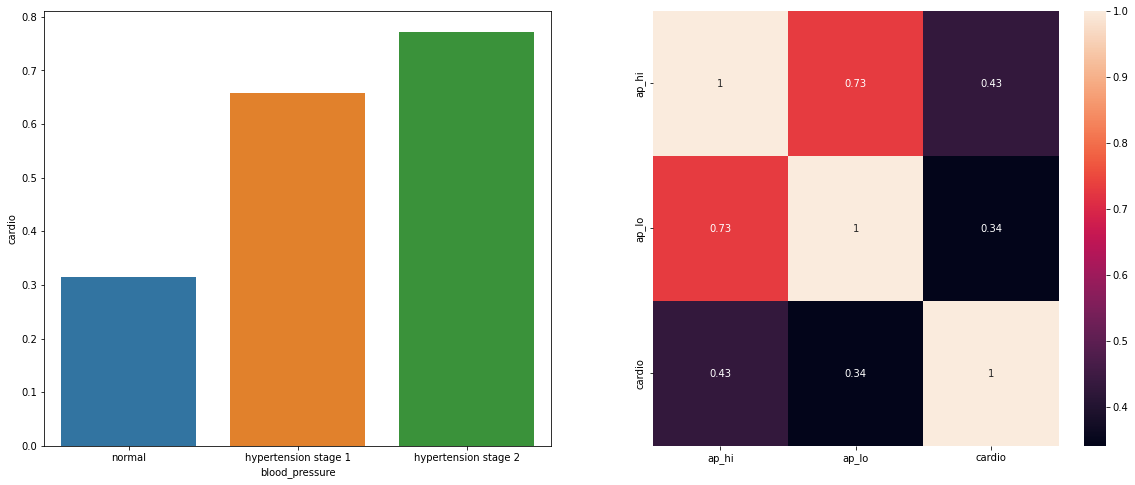

In [22]:
aux = df4[['blood_pressure', 'cardio']].groupby('blood_pressure').mean().reset_index().sort_values('cardio')

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='blood_pressure', y='cardio', data=aux)
plt.subplot(1,2,2)
sns.heatmap(df4[['ap_hi', 'ap_lo', 'cardio']].corr(method='pearson'), annot=True)

6 - Quanto pior o quadro de colesterol, maior é a chance de um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

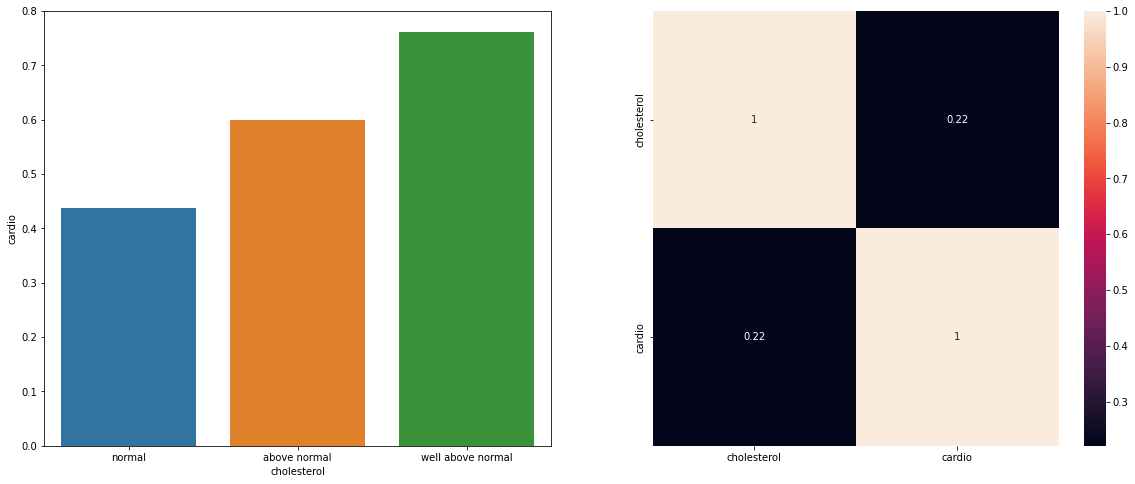

In [23]:
aux = df4[['cholesterol', 'cardio']].groupby('cholesterol').mean().reset_index()

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
sns.barplot(x='cholesterol', y='cardio', data=aux).set_xticklabels(['normal', 'above normal', 'well above normal'])

plt.subplot(1,2,2)
sns.heatmap(df4[['cholesterol', 'cardio']].corr(method='pearson'), annot=True)

7 - Quanto pior o quadro de diabetes, maior é a chance de ter um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

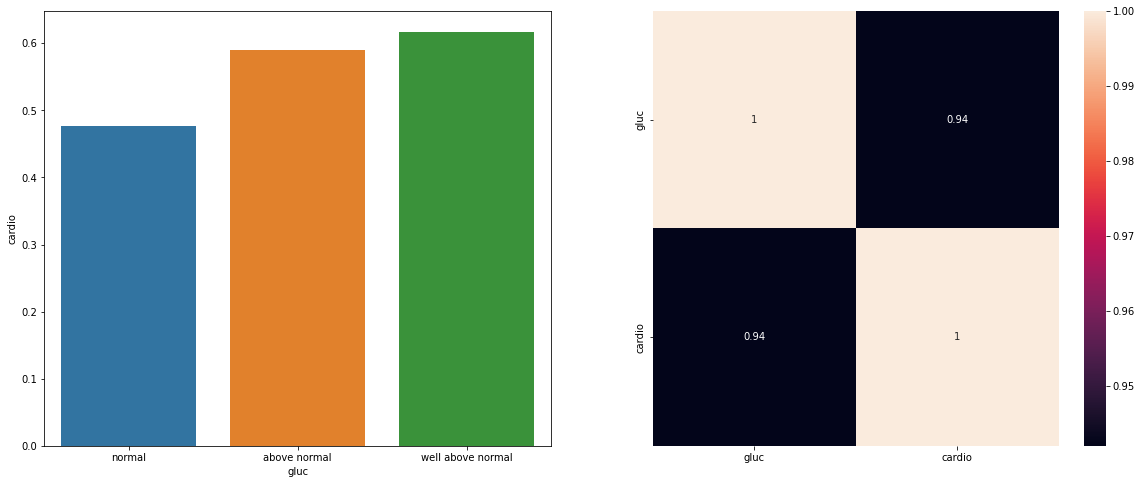

In [24]:
aux = df4[['gluc', 'cardio']].groupby('gluc').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='gluc', y='cardio', data=aux).set_xticklabels(['normal', 'above normal', 'well above normal'])

plt.subplot(1,2,2)
sns.heatmap(aux.corr(method='pearson'), annot=True)

8 - Pessoas que fumam, tem em média maior chance de ter um ataque cardiaco. (Falso!)

<AxesSubplot:>

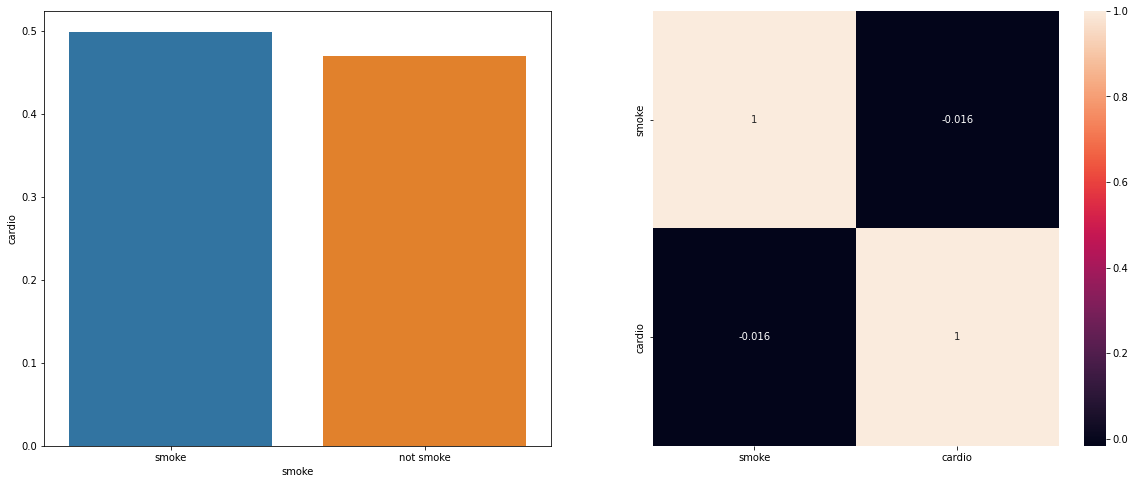

In [25]:
aux = df4[['smoke', 'cardio']].groupby('smoke').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='smoke', y='cardio', data=aux).set_xticklabels(['smoke', 'not smoke'])

plt.subplot(1,2,2)
sns.heatmap(df4[['smoke', 'cardio']].corr(method='pearson'), annot=True)

9 - Pessoas que alcool, tem em média maior chance de ter um ataque cardiaco. (Falso!)

<AxesSubplot:>

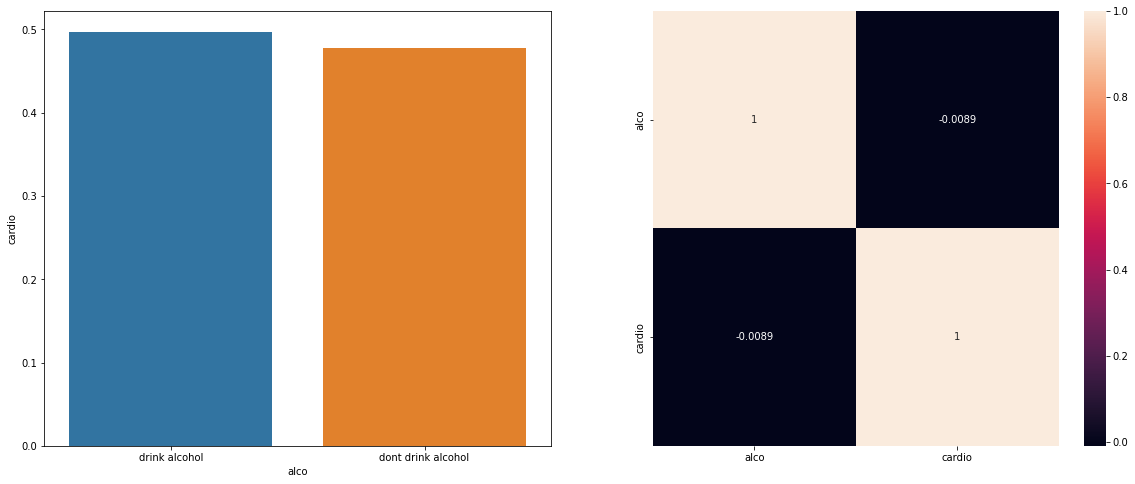

In [26]:
aux = df4[['alco', 'cardio']].groupby('alco').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='alco', y='cardio', data=aux).set_xticklabels(['drink alcohol', 'dont drink alcohol'])

plt.subplot(1,2,2)
sns.heatmap(df4[['alco', 'cardio']].corr(method='pearson'), annot=True)

10 - Pessoas que alcool, tem em média menor chance de ter um ataque cardiaco. (Falso!)

<AxesSubplot:>

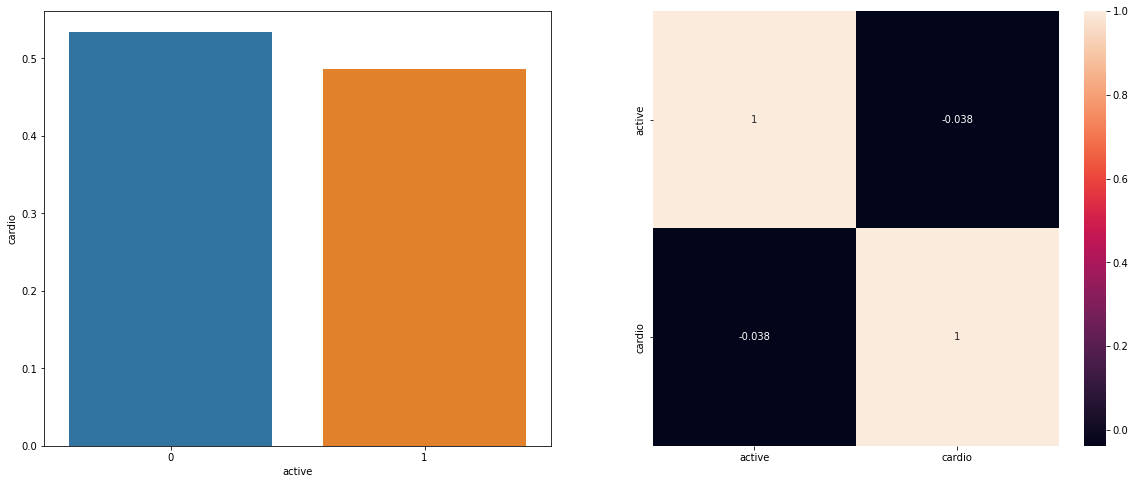

In [27]:
aux = df4[['active', 'cardio']].groupby('active').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='active', y='cardio', data=aux)

plt.subplot(1,2,2)
sns.heatmap(df4[['active', 'cardio']].corr(method='pearson'), annot=True)

11 - Pessoas com imc maior, em média tem mais propenção a ter um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

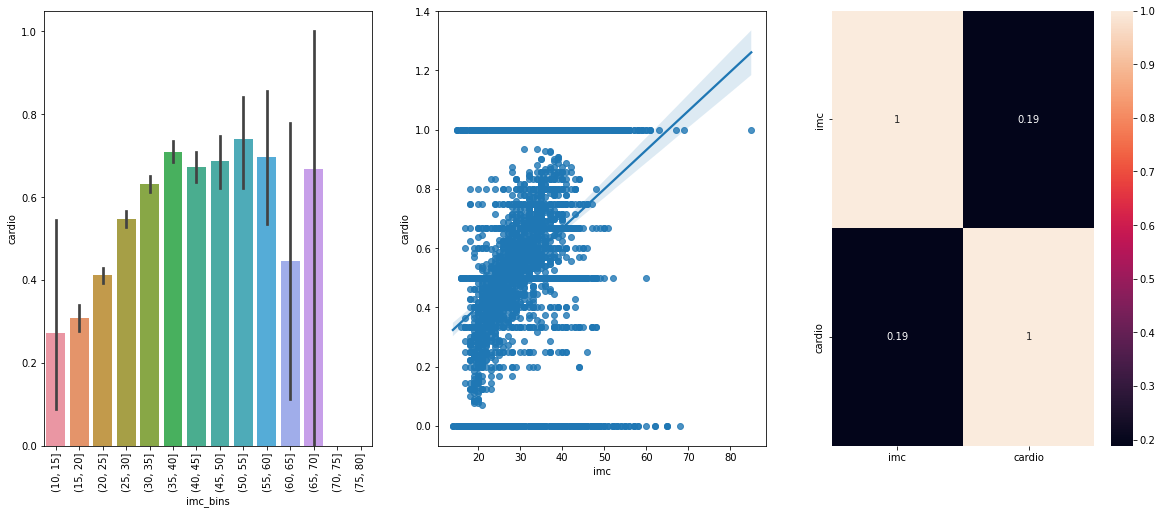

In [28]:
aux = df4[['imc', 'cardio']].groupby('imc').mean().reset_index()
aux['imc'] = np.int64(aux['imc'])

bins = list(np.arange(10,85, 5))

aux['imc_bins'] = pd.cut(aux['imc'], bins=bins)
aux1 = aux[['imc_bins', 'cardio']].groupby('imc_bins').sum().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='imc_bins', y='cardio', data=aux)
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.regplot(x='imc', y='cardio', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4[['imc', 'cardio']].corr(method='pearson'), annot=True)

## 4.3 Análise Multivariada

### 4.5.1 Variáveis Numéricas

<AxesSubplot:>

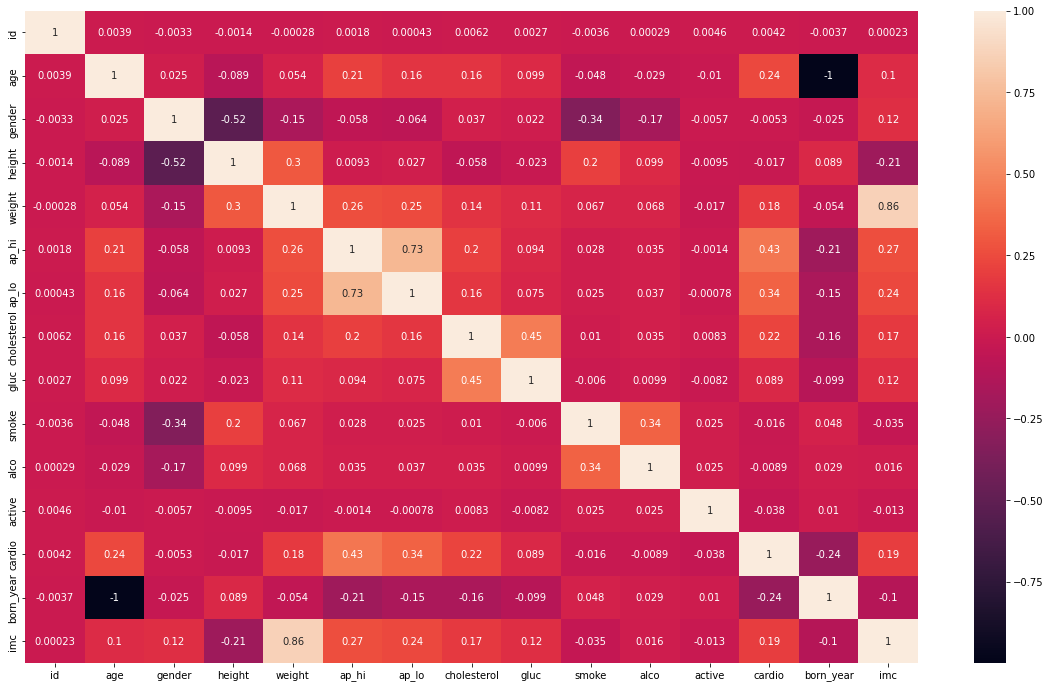

In [29]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(20,12))
sns.heatmap(num_attributes.corr(method='pearson'), annot=True)

# 5.0 PREPARAÇÃO DOS DADOS

In [30]:
df5 = df4.copy()

## 5.1 Rescaling

In [31]:
df5['age'] = mms.fit_transform(df5[['age']].values)
pickle.dump(mms, open('parameters/age.pkl', 'wb'))

df5['born_year'] = mms.fit_transform(df5[['born_year']].values)
pickle.dump(mms, open('parameters/ap_lo.pkl', 'wb'))

df5['age'] = mms.fit_transform(df5[['age']].values)
pickle.dump(mms, open('parameters/age.pkl', 'wb'))

df5['height'] = rs.fit_transform(df5[['height']].values)
pickle.dump(rs, open('parameters/height.pkl', 'wb'))

df5['weight'] = rs.fit_transform(df5[['weight']].values)
pickle.dump(rs, open('parameters/weight.pkl', 'wb'))

df5['ap_hi'] = rs.fit_transform(df5[['ap_hi']].values)
pickle.dump(rs, open('parameters/ap_hi.pkl', 'wb'))

df5['ap_lo'] = rs.fit_transform(df5[['ap_lo']].values)
pickle.dump(rs, open('parameters/ap_lo.pkl', 'wb'))

df5['imc'] = rs.fit_transform(df5[['imc']].values)
pickle.dump(rs, open('parameters/imc.pkl', 'wb'))




## 5.2 Encoding

In [32]:
bs_dict = {'normal': 1, 'hypertension stage 1': 2, 'hypertension stage 2': 3}
df5['blood_pressure'] = df5['blood_pressure'].map(bs_dict)

# 6.0 SELEÇÃO DE FEATURES

In [33]:
df6 = df5.copy()

## 6.1 Separando DataFrame em treino e teste

In [34]:
y = df6['cardio']
X = df6.drop(['id', 'cardio'], axis=1)

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [36]:
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

#rf = RandomForestRegressor(n_jobs=-1)

#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [37]:
#cols_selected = boruta.support_.tolist()
#cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()
#cols_not_selected_boruta = list(np.setdiff1d( X_train.columns, cols_selected_boruta))

In [38]:
#cols_selected_boruta

# 7.0 MACHINE LEARNING

In [39]:
X_test.drop('smoke', axis=1)
X_train.drop('smoke', axis=1)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,alco,active,born_year,imc,blood_pressure
38577,0.858769,1,0.000000,1.176471,1.5,1.0,1,1,0,1,0.138889,1.188644,3
57662,0.305459,0,0.909091,-1.294118,0.0,0.0,1,1,0,1,0.694444,-1.608463,1
54269,0.735501,1,-0.636364,-0.117647,0.0,-1.0,1,1,0,1,0.277778,0.267467,1
2635,0.634998,1,-0.636364,0.470588,0.0,0.0,1,1,0,1,0.361111,0.908976,1
15197,0.738986,1,0.000000,0.000000,0.0,0.0,1,1,0,1,0.250000,0.012178,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2842,0.559350,0,0.272727,0.000000,0.0,0.0,1,1,0,1,0.444444,-0.137731,1
37542,0.516686,1,-0.090909,-1.176471,-0.5,-1.0,1,1,0,1,0.472222,-1.126871,1
39701,0.967325,1,-0.909091,0.764706,1.0,0.0,2,1,0,1,0.027778,1.442851,2
9121,0.634301,0,0.909091,0.294118,0.0,0.0,1,1,0,1,0.361111,-0.196561,1


## 7.1 Logistic Regression 

In [252]:
lr = LogisticRegression().fit(X_train, y_train)

yhat_lr = lr.predict(X_test)

model_log_reg = accuracy_score(yhat_lr, y_test)
model_log_reg 

0.7178053982496139

### 7.1.1 Logistic Regression CV

In [310]:
lr = LogisticRegression()
lr_cv = cross_valid_model(model_name = 'Logistic Regrssion CV',model = lr, X = X, y = y, X_size=0.75)
lr_cv

Kfold: 1
Kfold: 2
Kfold: 3
Kfold: 4


,accuracy_score,precision_score,recall_score,f_score,roc_auc
Logistic Regrssion CV,0.724505,0.666479,0.750401,0.705953,0.727244


## 7.2 XGBoot Classifier

In [311]:
xgb_class = xgb.XGBClassifier(learning_rate = 0.00292, 
                              n_estimators = 2900, 
                              max_depth= 7, 
                              random_state=13).fit(X_train, y_train)


yhat_xbg = xgb_class.predict(X_test)

model_xgb_class = accuracy_score(yhat_xbg, y_test)
model_xgb_class

0.726630874457601

### 7.2.1 XGBoot Classifier CV

In [316]:
xgb_class = xgb.XGBClassifier(learning_rate = 0.00292, 
                              n_estimators = 2900, 
                              max_depth= 7, 
                              random_state=13)

xgb_cv = cross_valid_model(model_name = 'XGBClassifier CV', model = xgb_class, X = X, y = y, X_size=0.75)
xgb_cv


Kfold: 1
Kfold: 2
Kfold: 3
Kfold: 4


## 7.3 Random Forest Classifier

In [42]:
rfc_class = RandomForestClassifier(n_estimators=100, criterion = "entropy").fit(X_train, y_train)

yhat_rfc = rfc_class.predict(X_test)

model_rfc_class = accuracy_score(yhat_rfc, y_test)
model_rfc_class

71.55801365027065

### 7.3.1 Random Forest Classifier CV

In [318]:
rfc_class = RandomForestClassifier(n_estimators=100, criterion = "entropy")

rfc_cv = cross_valid_model(model_name = 'RandomForestClassifier', model = rfc_class, X = X, y = y, X_size=0.75)
rfc_cv

Kfold: 1
Kfold: 2
Kfold: 3
Kfold: 4


,accuracy_score,precision_score,recall_score,f_score,roc_auc
RandomForestClassifier,0.714693,0.695807,0.71987,0.707624,0.7149


## 7.4 Bagging Classifier

In [43]:
bgg_class = BaggingClassifier(n_estimators=100).fit(X_train, y_train)

yhat_bgg = bgg_class.predict(X_test)

model_bgg_class = accuracy_score(yhat_bgg, y_test)
model_bgg_class

70.86961638032479

### 7.4.1 Bagging Classifier CV

In [319]:
bgg_class = BaggingClassifier(n_estimators=100)

rfc_cv = cross_valid_model(model_name = 'BaggingClassifier', model = bgg_class, X = X, y = y, X_size=0.75)
rfc_cv

Kfold: 1
Kfold: 2
Kfold: 3
Kfold: 4


## 7.5 KNeighbors Classifier

In [44]:
knb_class = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

yhat_knb = knb_class.predict(X_test)

model_knb_class = accuracy_score('KNeighborsClassifier', yhat_knb, y_test)
model_knb_class

69.48693810308308

### 7.5.1 KNeighbors Classifier

In [320]:
knb_class = KNeighborsClassifier(n_neighbors=5)

knb_cv = cross_valid_model(model_name = 'KNeighborsClassifier', model = knb_class, X = X, y = y, X_size=0.75)
knb_cv

Kfold: 1
Kfold: 2
Kfold: 3
Kfold: 4


## 7.6 Decision Tree Classifier

In [322]:
dtc_class = DecisionTreeClassifier(criterion = "entropy").fit(X_train, y_train)

yhat_dtc = dtc_class.predict(X_test)

model_dtc_class = accuracy_score(yhat_dtc, y_test)
model_dtc_class

0.624770169890417

### 7.6.1 Decision Tree Classifier CV

In [324]:
dtc_class = DecisionTreeClassifier(criterion = "entropy")

dtc_cv = cross_valid_model(model_name = 'DecisionTreeClassifier', model = dtc_class, X = X, y = y, X_size=0.75)
dtc_cv

Kfold: 1
Kfold: 2
Kfold: 3
Kfold: 4


,accuracy_score,precision_score,recall_score,f_score,roc_auc
KNeighborsClassifier,0.6356,0.632638,0.632871,0.632746,0.635582


## 7.7 Support Vector Classification

In [46]:
svc_class = SVC().fit(X_train, y_train)

yhat_svc = svc_class.predict(X_test)

model_svc_class = accuracy_score(yhat_svc, y_test)
svc_class

### 7.7.1 Support Vector Classification

In [326]:
svc_class = SVC()
svc_cv = cross_valid_model(model_name = 'SVC', model = svc_class, X = X, y = y, X_size=0.75, verbose=1)
svc_cv

Kfold: 1
Kfold: 2
Kfold: 3


## 7.8 Beyes Gaussian

In [ ]:
gnb_class = GaussianNB().fit(X_train, y_train)

yhat_gnb = gnb_class.predict(X_test)

model_gnb_class = accuracy_score(yhat_gnb, y_test)
model_gnb_class


### 7.8.1 Beyes Gaussian CV

In [ ]:
gnb_class = GaussianNB()

gnb_cv = cross_valid_model(model_name = 'GaussianNB', model = gnb_class, X = X, y = y, X_size=0.75, verbose=1)
gnb_cv

## 7.9 MLP Classifier

In [ ]:
mlp_class = MLPClassifier(hidden_layer_sizes=(75,75), activation="logistic", random_state=1, max_iter=2000).fit(X_train, y_train)

yhat_mlp = mlp_class.predict(X_test)

model_mlp_class = accuracy_score(yhat_mlp, y_test)
model_mlp_class

In [ ]:
mlp_class = MLPClassifier(hidden_layer_sizes=(75,75), activation="logistic", random_state=1, max_iter=2000)

mlp_cv = cross_valid_model(model_name = 'MLPClassifier', model = mlp_class, X = X, y = y, X_size=0.75, verbose=1)
mlp_cv

## 7.10 Métricas dos Modelos

In [ ]:
index = ['BaggingClassifier', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'LogisticRegression', 'RandomForestClassifier', 'SVC',  'GaussianNB', 'XGBootClassifier', 'MLPClassifier']

dict_scores = {
'accuracy' :        [accuracy_score(yhat_bgg, y_test), 
                    accuracy_score(yhat_dtc, y_test),
                    accuracy_score(yhat_knb, y_test),
                    accuracy_score(yhat_lr, y_test),
                    accuracy_score(yhat_rfc, y_test), 
                    accuracy_score(yhat_svc, y_test),
                    accuracy_score(yhat_gnb, y_test),
                    accuracy_score(yhat_xbg, y_test),
                    accuracy_score(yhat_mlp, y_test)],

'precision' :       [precision_score(yhat_bgg, y_test), 
                    precision_score(yhat_dtc, y_test),
                    precision_score(yhat_knb, y_test),
                    precision_score(yhat_lr, y_test),
                    precision_score(yhat_rfc, y_test), 
                    precision_score(yhat_svc, y_test),
                    precision_score(yhat_gnb, y_test),
                    precision_score(yhat_xbg, y_test),
                    precision_score(yhat_mlp, y_test)],


'recall' :          [recall_score(yhat_bgg, y_test), 
                    recall_score(yhat_dtc, y_test),
                    recall_score(yhat_knb, y_test),
                    recall_score(yhat_lr, y_test),
                    recall_score(yhat_rfc, y_test), 
                    recall_score(yhat_svc, y_test),
                    recall_score(yhat_gnb, y_test), 
                    recall_score(yhat_xbg, y_test),
                    recall_score(yhat_mlp, y_test)], 

'f1_score' :        [f1_score(yhat_bgg, y_test), 
                    f1_score(yhat_dtc, y_test),
                    f1_score(yhat_knb, y_test),
                    f1_score(yhat_lr, y_test),
                    f1_score(yhat_rfc, y_test), 
                    f1_score(yhat_svc, y_test),
                    f1_score(yhat_gnb, y_test),
                    f1_score(yhat_xbg, y_test),
                    f1_score(yhat_mlp, y_test)],

'roc_auc' :         [roc_auc_score(yhat_bgg, y_test), 
                    roc_auc_score(yhat_dtc, y_test),
                    roc_auc_score(yhat_knb, y_test),
                    roc_auc_score(yhat_lr, y_test),
                    roc_auc_score(yhat_rfc, y_test), 
                    roc_auc_score(yhat_svc, y_test),
                    roc_auc_score(yhat_gnb, y_test),
                    roc_auc_score(yhat_xbg, y_test),
                    roc_auc_score(yhat_mlp, y_test)]}

df_scores = pd.DataFrame(dict_scores, index=index)
df_scores

ValueError: Found input variables with inconsistent numbers of samples: [16996, 13597]